# 🚗 CO₂ Emissions Prediction using Regression

This notebook predicts CO₂ emissions using a machine learning regression pipeline. It includes:
- Data loading & cleaning
- Exploratory Data Analysis (EDA)
- Preprocessing with encoding and scaling
- Feature selection (ANOVA + Random Forest)
- Model training, tuning, and comparison


## 📦 Step 1: Import Required Libraries


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


## 📂 Step 2: Load the Dataset


In [31]:
df = pd.read_csv("1995-2024_fuel_consumption.csv", encoding='latin1')


## 🧹 Step 3: Data Cleaning
- Drop unnamed or irrelevant columns
- Check for missing values
- Handle duplicates


In [32]:
df.drop_duplicates(inplace=True)
print(" Data shape after cleaning:", df.shape)


 Data shape after cleaning: (27722, 14)


## 🔍 Step 4: Initial Data Overview


In [33]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27722 entries, 0 to 27721
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            27722 non-null  int64  
 1   Make                  27722 non-null  object 
 2   Model                 27722 non-null  object 
 3   Vehicle class         27722 non-null  object 
 4   Engine size (L)       27722 non-null  float64
 5   Cylinders             27722 non-null  int64  
 6   Transmission          27722 non-null  object 
 7   Fuel type             27722 non-null  object 
 8   City (L/100 km)       27722 non-null  float64
 9   Highway (L/100 km)    27722 non-null  float64
 10  Combined (L/100 km)   27722 non-null  float64
 11  Combined (mpg)        27722 non-null  int64  
 12  CO2 emissions (g/km)  27722 non-null  int64  
 13  Unnamed: 13           4525 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 3.0+ MB


,Model year,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),Unnamed: 13
count,27722.000000,27722.00000,27722.000000,27722.000000,27722.000000,27722.000000,27722.000000,27722.000000,4525.000000
mean,2010.403506,3.34126,5.829125,12.800310,8.970457,11.077422,27.246591,252.074886,4.944530
std,8.179338,1.34147,1.806018,3.468786,2.276925,2.891569,7.314958,60.371529,1.734797
min,1995.000000,0.80000,2.000000,3.500000,3.200000,3.600000,11.000000,83.000000,1.000000
25%,2004.000000,2.20000,4.000000,10.500000,7.400000,9.100000,22.000000,210.000000,3.000000
50%,2011.000000,3.00000,6.000000,12.300000,8.500000,10.600000,27.000000,245.000000,5.000000
75%,2017.000000,4.20000,8.000000,14.800000,10.300000,12.800000,31.000000,291.000000,6.000000
max,2024.000000,8.40000,16.000000,30.700000,20.900000,26.100000,78.000000,608.000000,8.000000


## 📈 Step 5: Target Variable Distribution


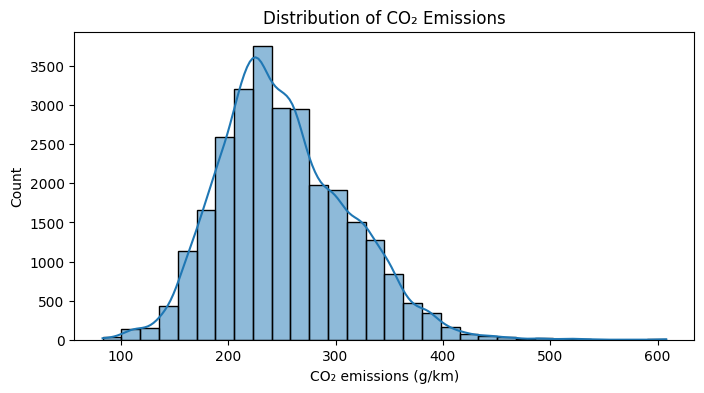

In [34]:
plt.figure(figsize=(8, 4))
sns.histplot(df['CO2 emissions (g/km)'], kde=True, bins=30)
plt.title("Distribution of CO₂ Emissions")
plt.xlabel("CO₂ emissions (g/km)")
plt.show()


## 🧠 Step 6: Identify Feature Types


In [35]:
X = df.drop(columns=['CO2 emissions (g/km)'])
y = df['CO2 emissions (g/km)']

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['Make', 'Model', 'Vehicle class', 'Transmission', 'Fuel type']
Numerical: ['Model year', 'Engine size (L)', 'Cylinders', 'City (L/100 km)', 'Highway (L/100 km)', 'Combined (L/100 km)', 'Combined (mpg)', 'Unnamed: 13']


## 📊 Step 7: Correlation Heatmap for Numerical Features


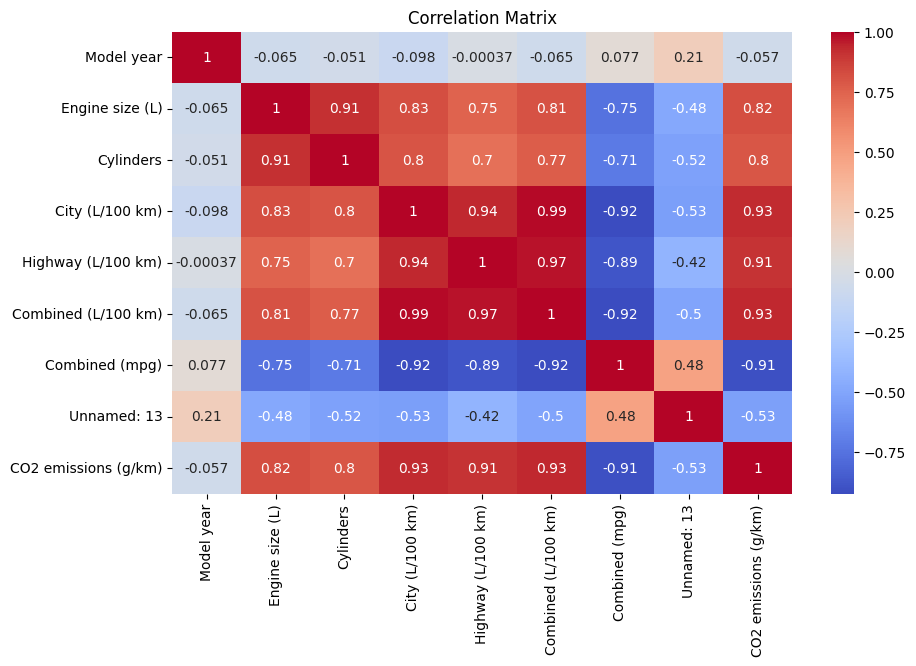

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols + ['CO2 emissions (g/km)']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


## 🎯 Step 8: One-Hot Encode Categorical Features + Scale Numerical


In [37]:
low_cardinality = [col for col in categorical_cols if df[col].nunique() < 10]
high_cardinality = [col for col in categorical_cols if df[col].nunique() >= 10]

preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numerical_cols),
    ('low_cat', OneHotEncoder(drop='first'), low_cardinality),
    ('high_cat', OneHotEncoder(drop='first', handle_unknown='ignore'), high_cardinality)
])


## ⚙️ Step 9: Transform Dataset


In [38]:
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_processed_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, columns=feature_names)

print("✅ Transformed shape:", X_processed_df.shape)


✅ Transformed shape: (27722, 4451)


## 🧪 Step 10: Feature Selection with ANOVA (F-test)


In [40]:
from sklearn.feature_selection import SelectKBest, f_regression

# Fill NaNs with column mean before feature selection
X_processed_df_filled = X_processed_df.fillna(X_processed_df.mean())

selector = SelectKBest(score_func=f_regression, k=15)
X_anova = selector.fit_transform(X_processed_df_filled, y)

anova_scores = selector.scores_
selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]

print("Top 15 Features via ANOVA:\n", selected_features)


Top 15 Features via ANOVA:
 ['num__Engine size (L)' 'num__Cylinders' 'num__City (L/100 km)'
 'num__Highway (L/100 km)' 'num__Combined (L/100 km)'
 'num__Combined (mpg)' 'num__Unnamed: 13' 'high_cat__Make_Bentley'
 'high_cat__Make_GMC' 'high_cat__Make_Lamborghini'
 'high_cat__Vehicle class_Pickup truck: Standard'
 'high_cat__Vehicle class_Sport utility vehicle: Standard'
 'high_cat__Vehicle class_Van: Passenger' 'high_cat__Transmission_AV'
 'high_cat__Transmission_M5']


## 🌲 Step 11: Feature Importance using Random Forest


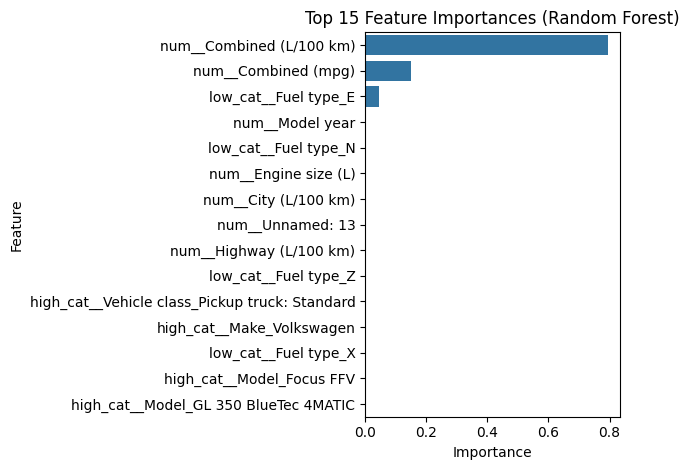

In [41]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_processed_df, y)

rf_importances = rf.feature_importances_

rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=rf_df.head(15))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


## 📊 Step 12: Combine ANOVA and Random Forest Scores


In [42]:
scaler = MinMaxScaler()
anova_scaled = scaler.fit_transform(anova_scores.reshape(-1, 1)).flatten()
rf_scaled = scaler.fit_transform(rf_importances.reshape(-1, 1)).flatten()
combined_score = (anova_scaled + rf_scaled) / 2

combined_df = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA_Score': anova_scaled,
    'RF_Score': rf_scaled,
    'Combined_Score': combined_score
})

selected_combined = combined_df[combined_df['Combined_Score'] >= 0.80]
final_features = selected_combined['Feature'].tolist()

print("Final Selected Features (Score ≥ 0.80):")
print(selected_combined[['Feature', 'Combined_Score']])


Final Selected Features (Score ≥ 0.80):
                    Feature  Combined_Score
5  num__Combined (L/100 km)             1.0


## 📈 Step 13: Trend Analysis — CO₂ vs Year


C:\Users\vaibh\AppData\Local\Temp\ipykernel_10816\3363094666.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Model year', y='CO2 emissions (g/km)', ci=None)


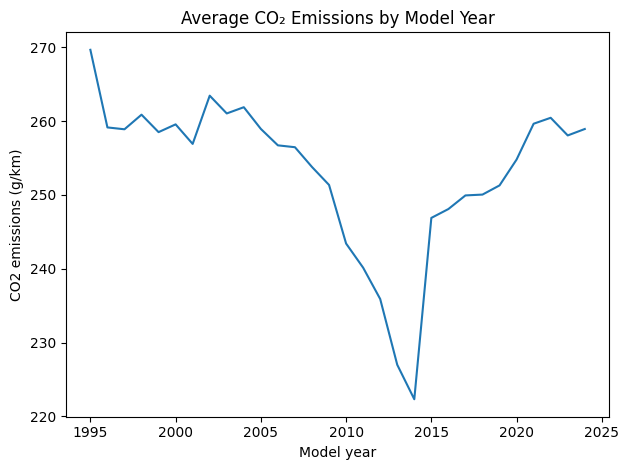

In [43]:
sns.lineplot(data=df, x='Model year', y='CO2 emissions (g/km)', ci=None)
plt.title("Average CO₂ Emissions by Model Year")
plt.tight_layout()
plt.show()


## 🧠 Step 14: Train-Test Split


In [44]:

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_df, y, test_size=0.2, random_state=42
)


## 🧮 Step 15: Define & Evaluate Multiple Models


In [45]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

## 🔎 Step 16: Grid Search for Random Forest & XGBoost


In [47]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Use only the final selected features for grid search to save memory
X_train_sel = X_train[final_features]
X_test_sel = X_test[final_features]

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train_sel, y_train)
best_rf = grid_rf.best_estimator_

# XGBoost
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=5, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train_sel, y_train)
best_xgb = grid_xgb.best_estimator_

# Add tuned models to evaluation
models['RandomForest'] = best_rf
models['XGBoost'] = best_xgb

## 📊 Step 17: Final Evaluation Table for All Models


In [49]:
# Fill NaNs in X_train and X_test with column means
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_train.mean())  

results = []

for name, model in models.items():
    scores = evaluate_model(model, X_train_filled, X_test_filled, y_train, y_test)
    scores['Model'] = name
    results.append(scores)

results_df = pd.DataFrame(results).set_index('Model')
results_df = results_df[['R2', 'MAE', 'MSE', 'RMSE']].sort_values(by='R2', ascending=False)

print("Final Model Comparison:")
print(results_df)


Final Model Comparison:
                            R2           MAE           MSE          RMSE
Model                                                                   
XGBoost           9.987351e-01  8.642743e-01  4.546329e+00  2.132212e+00
RandomForest      9.979742e-01  9.241026e-01  7.281495e+00  2.698425e+00
Ridge             9.965520e-01  1.954532e+00  1.239320e+01  3.520398e+00
GradientBoosting  9.964750e-01  1.849776e+00  1.267002e+01  3.559497e+00
LinearRegression -1.134639e+17  1.664702e+09  4.078264e+20  2.019471e+10


## 📊 Step 18: Checking of Overfitting for All Models


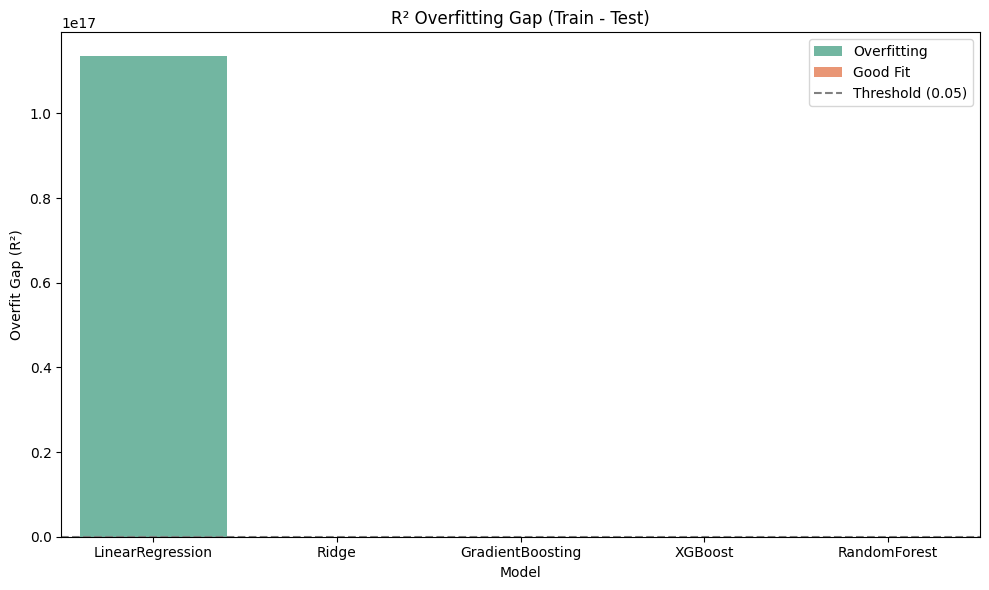

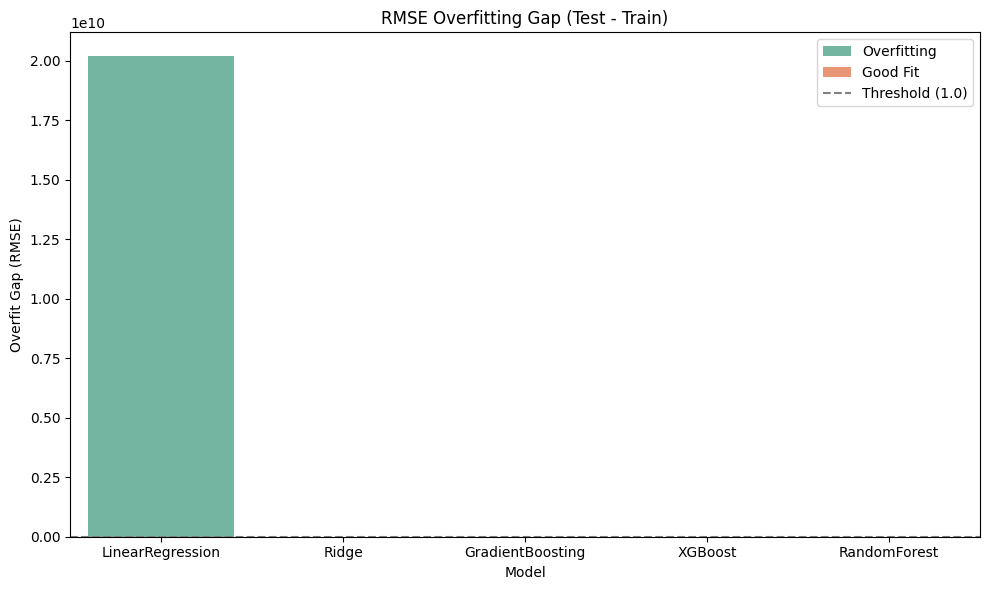

✅ Overfitting Evaluation Summary:


,Train_R2,Test_R2,Overfit_Gap_R2,Train_RMSE,Test_RMSE,Overfit_Gap_RMSE,Status
Model,,,,,,,
XGBoost,0.999426,9.987351e-01,6.912947e-04,1.448311,2.132212e+00,6.839008e-01,Good Fit
RandomForest,0.999214,9.979742e-01,1.239744e-03,1.695528,2.698425e+00,1.002896e+00,Good Fit
Ridge,0.997353,9.965520e-01,8.012143e-04,3.111204,3.520398e+00,4.091933e-01,Good Fit
GradientBoosting,0.996764,9.964750e-01,2.886250e-04,3.440327,3.559497e+00,1.191696e-01,Good Fit
LinearRegression,0.997556,-1.134639e+17,1.134639e+17,2.989557,2.019471e+10,2.019471e+10,Overfitting


In [52]:
# Step 1: Calculate train metrics and gaps
overfit_results = []

for name, model in models.items():
    model.fit(X_train_filled, y_train)
    y_train_pred = model.predict(X_train_filled)
    y_test_pred = model.predict(X_test_filled)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    overfit_results.append({
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Overfit_Gap_R2': train_r2 - test_r2,
        'Overfit_Gap_RMSE': test_rmse - train_rmse
    })

# Step 2: Create DataFrame and label status
overfit_df = pd.DataFrame(overfit_results).set_index('Model')

def label_status(row, r2_thresh=0.05, rmse_thresh=1.0):
    if row['Overfit_Gap_R2'] > r2_thresh and row['Overfit_Gap_RMSE'] > rmse_thresh:
        return 'Overfitting'
    elif row['Overfit_Gap_R2'] < -r2_thresh:
        return 'Underfitting'
    else:
        return 'Good Fit'

overfit_df['Status'] = overfit_df.apply(label_status, axis=1)

# Step 3: Plot Overfit Gap (R²)
plt.figure(figsize=(10, 6))
sns.barplot(x=overfit_df.index, y='Overfit_Gap_R2', hue='Status', data=overfit_df, palette='Set2')
plt.axhline(0.05, ls='--', color='gray', label='Threshold (0.05)')
plt.title('R² Overfitting Gap (Train - Test)')
plt.ylabel('Overfit Gap (R²)')
plt.xlabel('Model')
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Plot Overfit Gap (RMSE)
plt.figure(figsize=(10, 6))
sns.barplot(x=overfit_df.index, y='Overfit_Gap_RMSE', hue='Status', data=overfit_df, palette='Set2')
plt.axhline(1.0, ls='--', color='gray', label='Threshold (1.0)')
plt.title('RMSE Overfitting Gap (Test - Train)')
plt.ylabel('Overfit Gap (RMSE)')
plt.xlabel('Model')
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Final sorted table
print("Overfitting Evaluation Summary:")
display(overfit_df[['Train_R2', 'Test_R2', 'Overfit_Gap_R2', 'Train_RMSE', 'Test_RMSE', 'Overfit_Gap_RMSE', 'Status']].sort_values(by='Test_R2', ascending=False))
